# Unsupervised Learning Trading Strategy

* Download/Load VN100 stocks prices data.
* Calculate different features and indicators on each stock.
* Aggregate on monthly level and filter top 150 most liquid stocks.
* Calculate Monthly Returns for different time-horizons.
* Download Fama-French Factors and Calculate Rolling Factor Betas.
* For each month fit a K-Means Clustering Algorithm to group similar assets based on their features.
* For each month select assets based on the cluster and form a portfolio based on Efficient Frontier max sharpe ratio optimization.
* Visualize Portfolio returns and compare to VN100 returns.

# All Packages Needed:
* pandas, numpy, matplotlib, statsmodels, pandas_datareader, datetime, yfinance, sklearn, PyPortfolioOpt

## 1. Download/Load VN100 stocks prices data.

In [53]:
from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import pandas_ta
import warnings
warnings.filterwarnings('ignore')
import requests

url = "https://www.tradingview.com/symbols/HOSE-VN100/components/"  # Set headers to mimic a real browser
headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64)"}


response = requests.get(url, headers=headers) # Get the HTML page with requests
response.raise_for_status()


vn100 = pd.read_html(response.text)[0]  # Parse tables with pandas

vn100['Symbol_prefix'] = vn100['Symbol'].str[:3]  # Lấy 3 ký tự đầu tiên

symbols_list = vn100['Symbol_prefix'].unique().tolist()

vn_symbols_list=[symbol + '.VN' for symbol in symbols_list]
end_date = '2025-08-25'

start_date = pd.to_datetime(end_date)-pd.DateOffset(365*8) # How about if i get more than 8 years of data?

df = yf.download(tickers = vn_symbols_list, 
                 start=start_date, 
                 end=end_date,
                 auto_adjust=False).stack()

df.index.names = ['date', 'ticker']

df.columns = df.columns.str.lower()

df

[*********************100%***********************]  100 of 100 completed


Price                  adj close          close           high           low  \
date       ticker                                                              
2017-08-28 ACB.VN    5116.395996    5609.886719    5649.254395   5432.732422   
           ANV.VN    3119.508545    3450.000000    3700.000000   3445.000000   
           BCG.VN    5933.282227    5933.282227    6103.047363   5882.353027   
           BID.VN   11458.047852   11458.047852   11603.824219  11399.737305   
           BSI.VN    9767.733398    9767.733398   10153.301758   9767.733398   
...                          ...            ...            ...           ...   
2025-08-22 VNM.VN   58700.000000   58700.000000   59900.000000  58500.000000   
           VPB.VN   35950.000000   35950.000000   38250.000000  35950.000000   
           VPI.VN   55000.000000   55000.000000   56500.000000  53900.000000   
           VRE.VN   30000.000000   30000.000000   30100.000000  28650.000000   
           VTP.VN  102600.000000  102600.000000  103900.000000  99900.000000   

Price                       open      volume  
date       ticker                             
2017-08-28 ACB.VN    5432.732422  13459342.0  
           ANV.VN    3700.000000    138080.0  
           BCG.VN    5882.353027    500195.0  
           BID.VN   11516.358398   2040122.0  
           BSI.VN   10153.301758     29129.0  
...                          ...         ...  
2025-08-22 VNM.VN   59800.000000   7210343.0  
           VPB.VN   38000.000000  75606560.0  
           VPI.VN   56100.000000   3497571.0  
           VRE.VN   29850.000000  10655500.0  
           VTP.VN  102600.000000   1138200.0  

[129848 rows x 6 columns]

## 2. Calculate features and technical indicators for each stock.

* Garman-Klass Volatility
* RSI
* Bollinger Bands
* ATR
* MACD
* Dollar Volume

\begin{equation}
\text{Garman-Klass Volatility} = \frac{(\ln(\text{High}) - \ln(\text{Low}))^2}{2} - (2\ln(2) - 1)(\ln(\text{Adj Close}) - \ln(\text{Open}))^2
\end{equation}

In [54]:
df['garman_klass_vol'] = ((np.log(df['high'])-np.log(df['low']))**2)/2-(2*np.log(2)-1)*((np.log(df['adj close'])-np.log(df['open']))**2)

df['rsi'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.rsi(close=x, length=20))

df['bb_low'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,0])
                                                          
df['bb_mid'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,1])
                                                          
df['bb_high'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,2])

def compute_atr(stock_data):
    atr = pandas_ta.atr(high=stock_data['high'],
                        low=stock_data['low'],
                        close=stock_data['close'],
                        length=14)
    return atr.sub(atr.mean()).div(atr.std())

df['atr'] = df.groupby(level=1, group_keys=False).apply(compute_atr)

def compute_macd(close):
    macd = pandas_ta.macd(close=close, length=20).iloc[:,0]
    return macd.sub(macd.mean()).div(macd.std())

df['macd'] = df.groupby(level=1, group_keys=False)['adj close'].apply(compute_macd)

df['vnd_volume'] = (df['adj close']*df['volume'])/1e6

df


Price                  adj close          close           high           low  \
date       ticker                                                              
2017-08-28 ACB.VN    5116.395996    5609.886719    5649.254395   5432.732422   
           ANV.VN    3119.508545    3450.000000    3700.000000   3445.000000   
           BCG.VN    5933.282227    5933.282227    6103.047363   5882.353027   
           BID.VN   11458.047852   11458.047852   11603.824219  11399.737305   
           BSI.VN    9767.733398    9767.733398   10153.301758   9767.733398   
...                          ...            ...            ...           ...   
2025-08-22 VNM.VN   58700.000000   58700.000000   59900.000000  58500.000000   
           VPB.VN   35950.000000   35950.000000   38250.000000  35950.000000   
           VPI.VN   55000.000000   55000.000000   56500.000000  53900.000000   
           VRE.VN   30000.000000   30000.000000   30100.000000  28650.000000   
           VTP.VN  102600.000000  102600.000000  103900.000000  99900.000000   

Price                       open      volume  garman_klass_vol        rsi  \
date       ticker                                                           
2017-08-28 ACB.VN    5432.732422  13459342.0         -0.000627        NaN   
           ANV.VN    3700.000000    138080.0         -0.008701        NaN   
           BCG.VN    5882.353027    500195.0          0.000650        NaN   
           BID.VN   11516.358398   2040122.0          0.000147        NaN   
           BSI.VN   10153.301758     29129.0          0.000170        NaN   
...                          ...         ...               ...        ...   
2025-08-22 VNM.VN   59800.000000   7210343.0          0.000147  43.385949   
           VPB.VN   38000.000000  75606560.0          0.000735  76.866181   
           VPI.VN   56100.000000   3497571.0          0.000958  52.958429   
           VRE.VN   29850.000000  10655500.0          0.001209  57.949607   
           VTP.VN  102600.000000   1138200.0          0.000771  29.524446   

Price                 bb_low     bb_mid    bb_high       atr      macd  \
date       ticker                                                        
2017-08-28 ACB.VN        NaN        NaN        NaN       NaN       NaN   
           ANV.VN        NaN        NaN        NaN       NaN       NaN   
           BCG.VN        NaN        NaN        NaN       NaN       NaN   
           BID.VN        NaN        NaN        NaN       NaN       NaN   
           BSI.VN        NaN        NaN        NaN       NaN       NaN   
...                      ...        ...        ...       ...       ...   
2025-08-22 VNM.VN  10.983062  11.019463  11.055864  0.244759  0.056421   
           VPB.VN  10.017625  10.285257  10.552889  6.599692  6.651516   
           VPI.VN  10.837387  10.907465  10.977542  2.876291  2.091293   
           VRE.VN  10.237805  10.294572  10.351339  1.827803  1.017642   
           VTP.VN  11.550945  11.639519  11.728094 -0.555503 -0.828290   

Price                vnd_volume  
date       ticker                
2017-08-28 ACB.VN  6.886332e+04  
           ANV.VN  4.307417e+02  
           BCG.VN  2.967798e+03  
           BID.VN  2.337582e+04  
           BSI.VN  2.845243e+02  
...                         ...  
2025-08-22 VNM.VN  4.232471e+05  
           VPB.VN  2.718056e+06  
           VPI.VN  1.923664e+05  
           VRE.VN  3.196650e+05  
           VTP.VN  1.167793e+05  

[129848 rows x 14 columns]

<Axes: xlabel='date'>

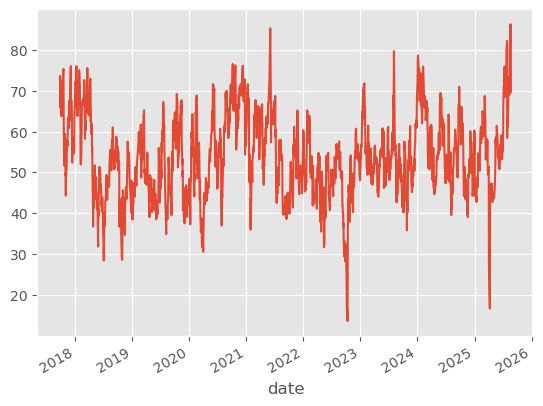

In [55]:
#Check out Value 
df.xs('ACB.VN',level=1)['rsi'].plot()

## 3. Aggregate to monthly level and filter top 150 most liquid stocks for each month.

* To reduce training time and experiment with features and strategies, we convert the business-daily data to month-end frequency.

In [56]:
last_cols = [c for c in df.columns.unique(0) if c not in ['vnd_volume', 'volume', 'open',
                                                          'high', 'low', 'close']]

data = (pd.concat([df.unstack('ticker')['vnd_volume'].resample('M').mean().stack('ticker').to_frame('vnd_volume'),
                   df.unstack()[last_cols].resample('M').last().stack('ticker')],
                  axis=1)).dropna()

data

vnd_volume      adj close  garman_klass_vol        rsi  \
date       ticker                                                             
2017-10-31 ACB.VN  1.578898e+05    5493.393066         -0.005580  49.194816   
           ANV.VN  2.699953e+03    3978.503418         -0.004298  49.351953   
           BCG.VN  2.777821e+03    4965.622559          0.002669  17.206194   
           BID.VN  4.698302e+04   12740.882812          0.000442  64.033993   
           BSI.VN  2.351717e+02    8546.766602          0.000487  34.694445   
...                         ...            ...               ...        ...   
2025-08-31 VNM.VN  3.666202e+05   58700.000000          0.000147  43.385949   
           VPB.VN  1.955287e+06   35950.000000          0.000735  76.866181   
           VPI.VN  1.570050e+05   55000.000000          0.000958  52.958429   
           VRE.VN  2.195291e+05   30000.000000          0.001209  57.949607   
           VTP.VN  8.141157e+04  102600.000000          0.000771  29.524446   

                      bb_low     bb_mid    bb_high       atr      macd  
date       ticker                                                       
2017-10-31 ACB.VN   8.602453   8.646863   8.691273 -0.930670  0.018258  
           ANV.VN   8.246768   8.354311   8.461854 -1.135543 -0.051435  
           BCG.VN   8.540269   8.643044   8.745820 -0.652006 -0.482269  
           BID.VN   9.337628   9.399792   9.461956 -1.715315  0.127605  
           BSI.VN   9.087915   9.135719   9.183523 -0.849773 -0.372532  
...                      ...        ...        ...       ...       ...  
2025-08-31 VNM.VN  10.983062  11.019463  11.055864  0.244759  0.056421  
           VPB.VN  10.017625  10.285257  10.552889  6.599692  6.651516  
           VPI.VN  10.837387  10.907465  10.977542  2.876291  2.091293  
           VRE.VN  10.237805  10.294572  10.351339  1.827803  1.017642  
           VTP.VN  11.550945  11.639519  11.728094 -0.555503 -0.828290  

[6208 rows x 9 columns]

* Calculate 5-year rolling average of dollar volume for each stocks before filtering.

In [57]:
data['vnd_volume'] = (data.loc[:, 'vnd_volume'].unstack('ticker').rolling(5*12, min_periods=12).mean().stack())

data['dollar_vol_rank'] = (data.groupby('date')['vnd_volume'].rank(ascending=False))

data = data[data['dollar_vol_rank']<150].drop(['vnd_volume', 'dollar_vol_rank'], axis=1)

data

adj close  garman_klass_vol        rsi     bb_low  \
date       ticker                                                          
2018-09-30 ACB.VN    7743.979004         -0.002916  56.455537   8.906080   
           ANV.VN    9946.258789         -0.003545  62.786882   8.968282   
           BCG.VN    5899.329590          0.001764  59.508870   8.434305   
           BID.VN   20525.357422          0.000336  61.164763   9.859760   
           BSI.VN    9426.217773          0.000275  73.396390   8.944812   
...                          ...               ...        ...        ...   
2025-08-31 VNM.VN   58700.000000          0.000147  43.385949  10.983062   
           VPB.VN   35950.000000          0.000735  76.866181  10.017625   
           VPI.VN   55000.000000          0.000958  52.958429  10.837387   
           VRE.VN   30000.000000          0.001209  57.949607  10.237805   
           VTP.VN  102600.000000          0.000771  29.524446  11.550945   

                      bb_mid    bb_high       atr      macd  
date       ticker                                            
2018-09-30 ACB.VN   8.937286   8.968491 -1.057216  0.078374  
           ANV.VN   9.119242   9.270203 -0.543994  0.652662  
           BCG.VN   8.637948   8.841592 -0.228294  0.726630  
           BID.VN   9.910151   9.960543 -0.670831  0.712371  
           BSI.VN   9.027966   9.111120 -1.013310  0.068797  
...                      ...        ...       ...       ...  
2025-08-31 VNM.VN  11.019463  11.055864  0.244759  0.056421  
           VPB.VN  10.285257  10.552889  6.599692  6.651516  
           VPI.VN  10.907465  10.977542  2.876291  2.091293  
           VRE.VN  10.294572  10.351339  1.827803  1.017642  
           VTP.VN  11.639519  11.728094 -0.555503 -0.828290  

[5108 rows x 8 columns]

## 4. Calculate Monthly Returns for different time horizons as features.

* To capture time series dynamics that reflect, for example, momentum patterns, we compute historical returns using the method .pct_change(lag), that is, returns over various monthly periods as identified by lags.

In [58]:
def calculate_returns(df):

    outlier_cutoff = 0.005

    lags = [1, 2, 3, 6, 9, 12]

    for lag in lags:

        df[f'return_{lag}m'] = (df['adj close']
                              .pct_change(lag)
                              .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                                     upper=x.quantile(1-outlier_cutoff)))
                              .add(1)
                              .pow(1/lag)
                              .sub(1))
    return df
    
    
data = data.groupby(level=1, group_keys=False).apply(calculate_returns).dropna()

data

adj close  garman_klass_vol        rsi     bb_low  \
date       ticker                                                         
2019-09-30 ACB.VN   6908.264648         -0.002832  61.592066   8.751680   
           ANV.VN  11777.274414         -0.005101  56.115670   9.290069   
           BCG.VN   7469.654297          0.000234  65.513141   8.771967   
           BID.VN  22974.406250          0.000332  57.895751   9.993463   
           BSI.VN   5394.857422          0.000094  42.795151   8.573142   
...                         ...               ...        ...        ...   
2025-08-31 VND.VN  22450.000000          0.000995  54.971220   9.980702   
           VNM.VN  58700.000000          0.000147  43.385949  10.983062   
           VPB.VN  35950.000000          0.000735  76.866181  10.017625   
           VPI.VN  55000.000000          0.000958  52.958429  10.837387   
           VRE.VN  30000.000000          0.001209  57.949607  10.237805   

                      bb_mid    bb_high       atr      macd  return_1m  \
date       ticker                                                        
2019-09-30 ACB.VN   8.803290   8.854899 -0.968798  0.069390   0.054054   
           ANV.VN   9.333733   9.377398 -0.861582 -0.038387   0.056795   
           BCG.VN   8.856224   8.940481 -0.358646  0.845227   0.086420   
           BID.VN  10.042701  10.091939 -1.078891  0.543232   0.016774   
           BSI.VN   8.588169   8.603196 -1.209604 -0.238632  -0.008439   
...                      ...        ...       ...       ...        ...   
2025-08-31 VND.VN  10.064568  10.148435  1.152774  1.609238  -0.011013   
           VNM.VN  11.019463  11.055864  0.244759  0.056421  -0.040850   
           VPB.VN  10.285257  10.552889  6.599692  6.651516   0.393411   
           VPI.VN  10.907465  10.977542  2.876291  2.091293   0.059730   
           VRE.VN  10.294572  10.351339  1.827803  1.017642   0.067616   

                   return_2m  return_3m  return_6m  return_9m  return_12m  
date       ticker                                                          
2019-09-30 ACB.VN   0.013072   0.017233   0.000659   0.003041   -0.009471  
           ANV.VN  -0.001914  -0.017894  -0.000956  -0.009938    0.014181  
           BCG.VN   0.229645   0.159164   0.065618   0.052762    0.019862  
           BID.VN   0.053499   0.075175   0.016098   0.015193    0.009438  
           BSI.VN  -0.043138  -0.054472  -0.039882  -0.030518   -0.045439  
...                      ...        ...        ...        ...         ...  
2025-08-31 VND.VN   0.142468   0.138331   0.092767   0.059634    0.036911  
           VNM.VN   0.006016   0.022559  -0.003847  -0.005893   -0.012680  
           VPB.VN   0.383986   0.256280   0.112460   0.074901    0.057044  
           VPI.VN   0.015822   0.009889  -0.013022  -0.006831   -0.002387  
           VRE.VN   0.103195   0.029428   0.094939   0.058912    0.037876  

[3930 rows x 14 columns]

## 5. Download Fama-French Factors and Calculate Rolling Factor Betas.

* We will introduce the Fama—French data to estimate the exposure of assets to common risk factors using linear regression.

* The five Fama—French factors, namely market risk, size, value, operating profitability, and investment have been shown empirically to explain asset returns and are commonly used to assess the risk/return profile of portfolios. Hence, it is natural to include past factor exposures as financial features in models.

* We can access the historical factor returns using the pandas-datareader and estimate historical exposures using the RollingOLS rolling linear regression.

In [59]:
factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3',
                               'famafrench',
                               start='2010')[0].drop('RF', axis=1)

factor_data.index = factor_data.index.to_timestamp()

factor_data = factor_data.resample('M').last().div(100)

factor_data.index.name = 'date'

factor_data = factor_data.join(data['return_1m']).sort_index()

factor_data


Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2019-09-30 ACB.VN  0.0142  0.0029  0.0676  0.0182  0.0338   0.054054
           ANV.VN  0.0142  0.0029  0.0676  0.0182  0.0338   0.056795
           BCG.VN  0.0142  0.0029  0.0676  0.0182  0.0338   0.086420
           BID.VN  0.0142  0.0029  0.0676  0.0182  0.0338   0.016774
           BSI.VN  0.0142  0.0029  0.0676  0.0182  0.0338  -0.008439
...                   ...     ...     ...     ...     ...        ...
2025-06-30 VHC.VN  0.0486 -0.0002 -0.0160 -0.0319  0.0145   0.075676
           VIB.VN  0.0486 -0.0002 -0.0160 -0.0319  0.0145   0.022346
           VIX.VN  0.0486 -0.0002 -0.0160 -0.0319  0.0145  -0.019231
           VND.VN  0.0486 -0.0002 -0.0160 -0.0319  0.0145   0.130101
           VPI.VN  0.0486 -0.0002 -0.0160 -0.0319  0.0145  -0.001873

[3737 rows x 6 columns]

* Filter out stocks with less than 10 months of data.

In [60]:
observations = factor_data.groupby(level=1).size()

valid_stocks = observations[observations >= 10]

factor_data = factor_data[factor_data.index.get_level_values('ticker').isin(valid_stocks.index)]

factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2019-09-30 ACB.VN  0.0142  0.0029  0.0676  0.0182  0.0338   0.054054
           ANV.VN  0.0142  0.0029  0.0676  0.0182  0.0338   0.056795
           BCG.VN  0.0142  0.0029  0.0676  0.0182  0.0338   0.086420
           BID.VN  0.0142  0.0029  0.0676  0.0182  0.0338   0.016774
           BSI.VN  0.0142  0.0029  0.0676  0.0182  0.0338  -0.008439
...                   ...     ...     ...     ...     ...        ...
2025-06-30 VHC.VN  0.0486 -0.0002 -0.0160 -0.0319  0.0145   0.075676
           VIB.VN  0.0486 -0.0002 -0.0160 -0.0319  0.0145   0.022346
           VIX.VN  0.0486 -0.0002 -0.0160 -0.0319  0.0145  -0.019231
           VND.VN  0.0486 -0.0002 -0.0160 -0.0319  0.0145   0.130101
           VPI.VN  0.0486 -0.0002 -0.0160 -0.0319  0.0145  -0.001873

[3737 rows x 6 columns]

* Calculate Rolling Factor Betas.

In [61]:
betas = (factor_data.groupby(level=1,
                            group_keys=False)
         .apply(lambda x: RollingOLS(endog=x['return_1m'], 
                                     exog=sm.add_constant(x.drop('return_1m', axis=1)),
                                     window=min(24, x.shape[0]),
                                     min_nobs=len(x.columns)+1)
         .fit(params_only=True)
         .params
         .drop('const', axis=1)))

betas 

Mkt-RF       SMB       HML       RMW       CMA
date       ticker                                                  
2019-09-30 ACB.VN       NaN       NaN       NaN       NaN       NaN
           ANV.VN       NaN       NaN       NaN       NaN       NaN
           BCG.VN       NaN       NaN       NaN       NaN       NaN
           BID.VN       NaN       NaN       NaN       NaN       NaN
           BSI.VN       NaN       NaN       NaN       NaN       NaN
...                     ...       ...       ...       ...       ...
2025-06-30 VHC.VN  1.539109  0.166321  0.210471  0.850978  1.915342
           VIB.VN  1.191289 -0.270452  0.671479  0.490035  0.326154
           VIX.VN  3.077738 -2.448465  2.872364  1.097726 -0.178065
           VND.VN  1.102136 -1.073294  1.320783 -1.164464  1.403927
           VPI.VN  0.124239  0.842872  0.221456  0.604016  0.265148

[3737 rows x 5 columns]

* Join the rolling factors data to the main features dataframe.

In [62]:
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']

data = (data.join(betas.groupby('ticker').shift()))

data.loc[:, factors] = data.groupby('ticker', group_keys=False)[factors].apply(lambda x: x.fillna(x.mean()))

data = data.drop('adj close', axis=1)

data = data.dropna()

data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 3790 entries, (Timestamp('2019-09-30 00:00:00'), 'ACB.VN') to (Timestamp('2025-08-31 00:00:00'), 'VPI.VN')
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   garman_klass_vol  3790 non-null   float64
 1   rsi               3790 non-null   float64
 2   bb_low            3790 non-null   float64
 3   bb_mid            3790 non-null   float64
 4   bb_high           3790 non-null   float64
 5   atr               3790 non-null   float64
 6   macd              3790 non-null   float64
 7   return_1m         3790 non-null   float64
 8   return_2m         3790 non-null   float64
 9   return_3m         3790 non-null   float64
 10  return_6m         3790 non-null   float64
 11  return_9m         3790 non-null   float64
 12  return_12m        3790 non-null   float64
 13  Mkt-RF            3790 non-null   float64
 14  SMB               3790 non-null   float64
 15  HML   

### At this point we have to decide on what ML model and approach to use for predictions etc.


## 6. For each month fit a K-Means Clustering Algorithm to group similar assets based on their features.

### K-Means Clustering
* You may want to initialize predefined centroids for each cluster based on your research.

* For visualization purpose of this tutorial we will initially rely on the ‘k-means++’ initialization.

* Then we will pre-define our centroids for each cluster.

In [63]:
target_rsi_values = [30, 45, 55, 70]

initial_centroids = np.zeros((len(target_rsi_values), 18))

initial_centroids[:, 1] = target_rsi_values

initial_centroids

array([[ 0., 30.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0., 45.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0., 55.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0., 70.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.]])

In [64]:
from sklearn.cluster import KMeans

#data = data.drop('cluster', axis=1)

def get_clusters(df):
    df['cluster'] = KMeans(n_clusters=4,
                           random_state=0,
                           init=initial_centroids).fit(df).labels_
    return df

data = data.dropna().groupby('date', group_keys=False).apply(get_clusters)

data

garman_klass_vol        rsi     bb_low     bb_mid  \
date       ticker                                                      
2019-09-30 ACB.VN         -0.002832  61.592066   8.751680   8.803290   
           ANV.VN         -0.005101  56.115670   9.290069   9.333733   
           BCG.VN          0.000234  65.513141   8.771967   8.856224   
           BID.VN          0.000332  57.895751   9.993463  10.042701   
           BSI.VN          0.000094  42.795151   8.573142   8.588169   
...                             ...        ...        ...        ...   
2025-08-31 VHC.VN          0.000637  44.473245  10.904666  10.969582   
           VIB.VN          0.006366  84.427872   9.785035   9.910354   
           VIX.VN          0.002889  75.318689  10.046010  10.308211   
           VND.VN          0.000995  54.971220   9.980702  10.064568   
           VPI.VN          0.000958  52.958429  10.837387  10.907465   

                     bb_high       atr      macd  return_1m  return_2m  \
date       ticker                                                        
2019-09-30 ACB.VN   8.854899 -0.968798  0.069390   0.054054   0.013072   
           ANV.VN   9.377398 -0.861582 -0.038387   0.056795  -0.001914   
           BCG.VN   8.940481 -0.358646  0.845227   0.086420   0.229645   
           BID.VN  10.091939 -1.078891  0.543232   0.016774   0.053499   
           BSI.VN   8.603196 -1.209604 -0.238632  -0.008439  -0.043138   
...                      ...       ...       ...        ...        ...   
2025-08-31 VHC.VN  11.034499  0.418831 -0.180664  -0.015901  -0.034082   
           VIB.VN  10.035673  2.126395  3.146494   0.216495   0.191813   
           VIX.VN  10.570412  5.136575  6.702428   0.263736   0.568598   
           VND.VN  10.148435  1.152774  1.609238  -0.011013   0.142468   
           VPI.VN  10.977542  2.876291  2.091293   0.059730   0.015822   

                   return_3m  return_6m  return_9m  return_12m    Mkt-RF  \
date       ticker                                                          
2019-09-30 ACB.VN   0.017233   0.000659   0.003041   -0.009471  0.465049   
           ANV.VN  -0.017894  -0.000956  -0.009938    0.014181  0.838181   
           BCG.VN   0.159164   0.065618   0.052762    0.019862  1.575846   
           BID.VN   0.075175   0.016098   0.015193    0.009438  0.864136   
           BSI.VN  -0.054472  -0.039882  -0.030518   -0.045439  0.949488   
...                      ...        ...        ...         ...       ...   
2025-08-31 VHC.VN   0.001200  -0.041657  -0.026305   -0.020687  0.703866   
           VIB.VN   0.134951   0.052006   0.043380    0.036233  1.200088   
           VIX.VN   0.366520   0.211622   0.153112    0.095307  1.801462   
           VND.VN   0.138331   0.092767   0.059634    0.036911  0.708032   
           VPI.VN   0.009889  -0.013022  -0.006831   -0.002387 -0.136469   

                        SMB       HML       RMW       CMA  cluster  
date       ticker                                                   
2019-09-30 ACB.VN  0.722591 -0.015059  0.268292 -0.440731        3  
           ANV.VN  1.200482 -1.319275 -1.651989  0.852811        2  
           BCG.VN -0.548634  0.005841 -1.609660 -1.143783        3  
           BID.VN -0.115945  0.407975 -0.354136 -0.233694        2  
           BSI.VN -0.840826  0.149141 -0.399423 -1.101040        1  
...                     ...       ...       ...       ...      ...  
2025-08-31 VHC.VN -0.172819 -0.374500 -1.331447  1.037390        1  
           VIB.VN  0.061726  0.072314  0.100984 -0.008194        3  
           VIX.VN -0.092927  0.043122 -0.551732 -2.109206        3  
           VND.VN  0.776246 -0.020475  0.603388 -1.123613        2  
           VPI.VN  0.054530 -0.114395  0.409102 -0.070624        1  

[3790 rows x 19 columns]

In [65]:
def plot_clusters(data, ax=None):
    if ax is None:
        ax = plt.gca()  

    cluster_0 = data[data['cluster'] == 0]
    cluster_1 = data[data['cluster'] == 1]
    cluster_2 = data[data['cluster'] == 2]
    cluster_3 = data[data['cluster'] == 3]

    ax.scatter(cluster_0.iloc[:, 5], cluster_0.iloc[:, 1], color='red', label='cluster 0')
    ax.scatter(cluster_1.iloc[:, 5], cluster_1.iloc[:, 1], color='green', label='cluster 1')
    ax.scatter(cluster_2.iloc[:, 5], cluster_2.iloc[:, 1], color='blue', label='cluster 2')
    ax.scatter(cluster_3.iloc[:, 5], cluster_3.iloc[:, 1], color='black', label='cluster 3')

    ax.legend()
    return ax


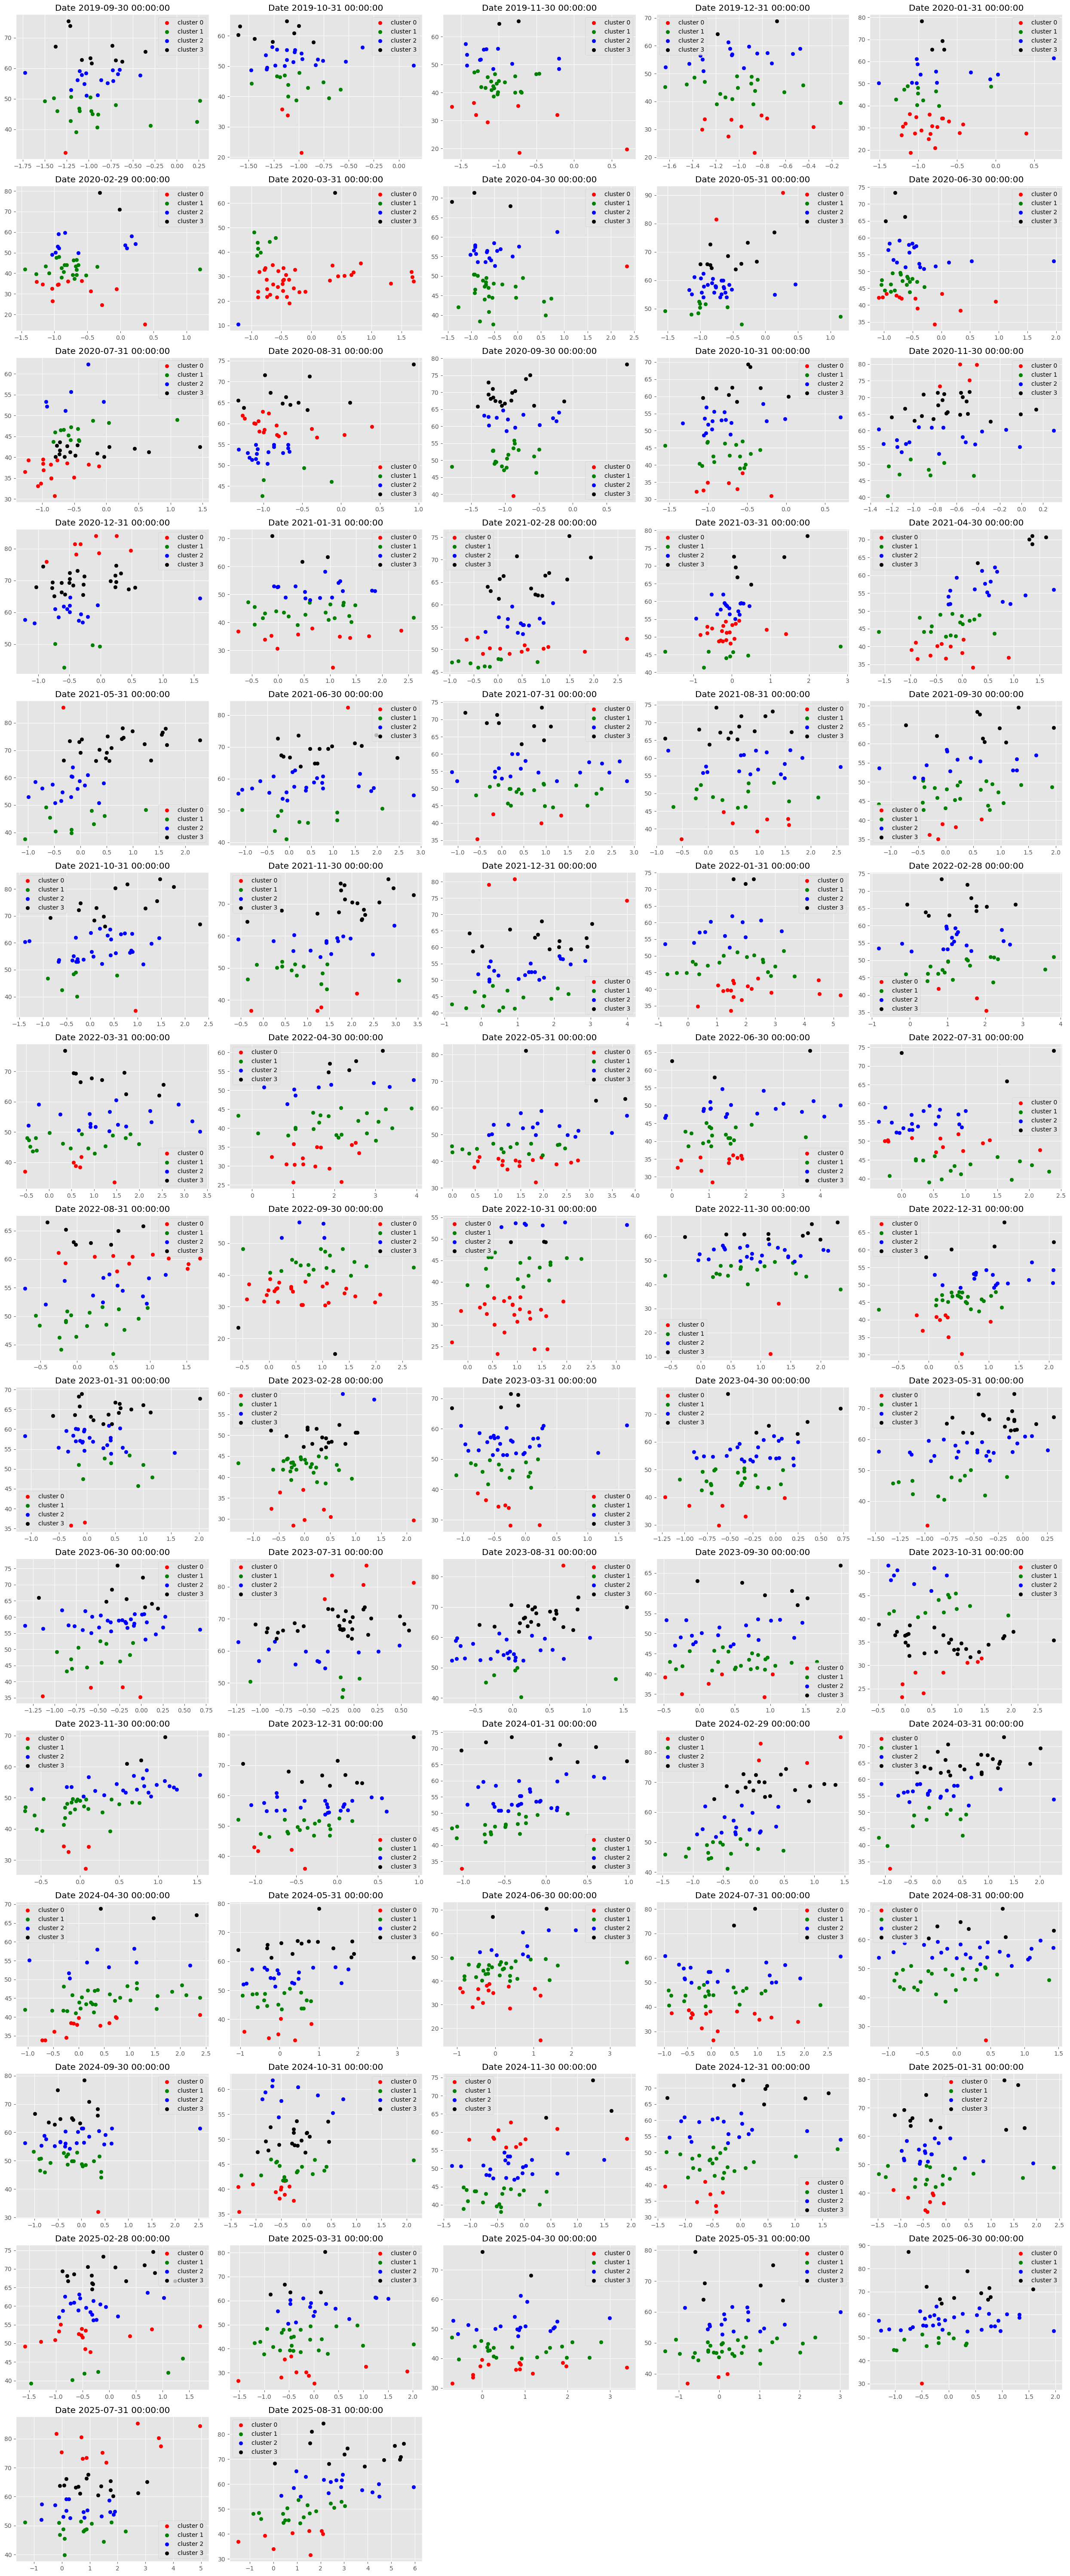

In [66]:
n_cols = 5
dates = data.index.get_level_values('date').unique().tolist()
n_rows = (len(dates) + n_cols - 1) // n_cols  

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
axes = axes.flatten()

for idx, i in enumerate(dates):
    g = data.xs(i, level=0)
    ax = axes[idx]
    ax.set_title(f'Date {i}')
    plot_clusters(g, ax=ax)

# xóa mấy subplot thừa
for j in range(len(dates), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


### Apply pre-defined centroids.

## 7. For each month select assets based on the cluster and form a portfolio based on Efficient Frontier max sharpe ratio optimization

* First we will filter only stocks corresponding to the cluster we choose based on our hypothesis.

* Momentum is persistent and my idea would be that stocks clustered around RSI 70 centroid should continue to outperform in the following month - thus I would select stocks corresponding to cluster 3.


In [67]:
filtered_df = data[data['cluster']==3].copy()

filtered_df = filtered_df.reset_index(level=1)

filtered_df.index = filtered_df.index+pd.DateOffset(1)

filtered_df = filtered_df.reset_index().set_index(['date', 'ticker'])

dates = filtered_df.index.get_level_values('date').unique().tolist()

fixed_dates = {}

for d in dates:
    
    fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d, level=0).index.tolist()
    
fixed_dates

{'2019-10-01': ['ACB.VN',
  'BCG.VN',
  'CII.VN',
  'DXG.VN',
  'FPT.VN',
  'HCM.VN',
  'IMP.VN',
  'KDH.VN',
  'MBB.VN',
  'SBT.VN'],
 '2019-11-01': ['ACB.VN',
  'CTG.VN',
  'FPT.VN',
  'KDH.VN',
  'MBB.VN',
  'SBT.VN',
  'VCB.VN',
  'VCG.VN'],
 '2019-12-01': ['FTS.VN', 'IMP.VN'],
 '2020-01-01': ['BID.VN', 'NKG.VN'],
 '2020-02-01': ['BSI.VN', 'CTG.VN', 'IMP.VN', 'SHB.VN'],
 '2020-03-01': ['SBT.VN', 'SHB.VN'],
 '2020-04-01': ['SHB.VN'],
 '2020-05-01': ['DBC.VN', 'PDR.VN', 'VCG.VN'],
 '2020-06-01': ['BCG.VN',
  'CTD.VN',
  'DBC.VN',
  'EIB.VN',
  'FRT.VN',
  'HDG.VN',
  'HPG.VN',
  'NKG.VN',
  'PC1.VN',
  'SJS.VN',
  'VCB.VN'],
 '2020-07-01': ['DGW.VN', 'FTS.VN', 'TLG.VN'],
 '2020-08-01': ['BID.VN',
  'CII.VN',
  'CTD.VN',
  'CTG.VN',
  'DIG.VN',
  'EIB.VN',
  'FPT.VN',
  'GAS.VN',
  'HDB.VN',
  'HDG.VN',
  'KDH.VN',
  'SAB.VN',
  'SHB.VN',
  'SJS.VN',
  'SSI.VN',
  'TLG.VN'],
 '2020-09-01': ['ACB.VN',
  'CMG.VN',
  'CTG.VN',
  'DPM.VN',
  'GEX.VN',
  'HDB.VN',
  'KDC.VN',
  'PDR.VN',
 

### Define portfolio optimization function

* We will define a function which optimizes portfolio weights using PyPortfolioOpt package and EfficientFrontier optimizer to maximize the sharpe ratio.

* To optimize the weights of a given portfolio we would need to supply last 1 year prices to the function.

* Apply signle stock weight bounds constraint for diversification (minimum half of equaly weight and maximum 10% of portfolio).

In [68]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

def optimize_weights(prices, lower_bound=0):
    
    returns = expected_returns.mean_historical_return(prices=prices,
                                                      frequency=252)
    
    cov = risk_models.sample_cov(prices=prices,
                                 frequency=252)
    
    ef = EfficientFrontier(expected_returns=returns,
                           cov_matrix=cov,
                           weight_bounds=(lower_bound, .1),
                           solver='SCS')
    
    weights = ef.max_sharpe()
    
    return ef.clean_weights()


* Download Fresh Daily Prices Data only for short listed stocks.

In [69]:
stocks = data.index.get_level_values('ticker').unique().tolist()

new_df = yf.download(tickers=stocks,
                     start=data.index.get_level_values('date').unique()[0]-pd.DateOffset(months=12),
                     end=data.index.get_level_values('date').unique()[-1],
                     auto_adjust = False)

new_df

[*********************100%***********************]  56 of 56 completed


Price          Adj Close                                           \
Ticker            ACB.VN        ANV.VN       BCG.VN        BID.VN   
Date                                                                
2018-10-01   7653.140625   9946.258789  5856.888184  20262.958984   
2018-10-02   7562.302246  10579.203125  5890.841309  21108.464844   
2018-10-03   7607.721191  10760.043945  5856.888184  21370.863281   
2018-10-04   7721.269531  10624.413086  5882.353027  21429.173828   
2018-10-05   7630.431152  10443.572266  5882.353027  20700.289062   
...                  ...           ...          ...           ...   
2025-08-25  26200.000000  25000.000000  3550.000000  41000.000000   
2025-08-26  27350.000000  26750.000000  3630.000000  41800.000000   
2025-08-27  27650.000000  26800.000000  3580.000000  42800.000000   
2025-08-28  27550.000000  28000.000000  3610.000000  42500.000000   
2025-08-29  27800.000000  27150.000000  3860.000000  42850.000000   

Price                                                               \
Ticker            BSI.VN        BWE.VN        CII.VN        CMG.VN   
Date                                                                 
2018-10-01   9600.133789  16801.195312  21254.845703  10692.404297   
2018-10-02   9426.217773  16630.625000  20785.988281  10400.385742   
2018-10-03   9287.085938  17355.548828  20629.703125  10332.996094   
2018-10-04   9461.000977  17099.693359  20785.988281  10332.996094   
2018-10-05   9391.434570  16801.195312  20434.343750  10288.070312   
...                  ...           ...           ...           ...   
2025-08-25  49700.000000  46850.000000  22700.000000  39100.000000   
2025-08-26  52900.000000  47000.000000  23950.000000  39700.000000   
2025-08-27  52100.000000  47550.000000  22600.000000  40600.000000   
2025-08-28  52600.000000  47300.000000  23100.000000  40900.000000   
2025-08-29  55000.000000  47200.000000  22500.000000  40300.000000   

Price                                    ...    Volume                        \
Ticker             CTD.VN        CTG.VN  ...    TLG.VN      TPB.VN    VCB.VN   
Date                                     ...                                   
2018-10-01  121768.890625  18755.521484  ...     108.0   1182382.0   4736967   
2018-10-02  120808.335938  18790.189453  ...    2190.0   1633185.0   3606980   
2018-10-03  120808.335938  19067.535156  ...    2081.0   2270140.0   2331567   
2018-10-04  121768.890625  19206.208984  ...    2928.0   3241459.0   5178851   
2018-10-05  122655.554688  18790.189453  ...     484.0   2440552.0   3680154   
...                   ...           ...  ...       ...         ...       ...   
2025-08-25   74100.000000  49100.000000  ...  108424.0  59724430.0   7867628   
2025-08-26   75600.000000  51200.000000  ...  115949.0  49749940.0   8209194   
2025-08-27   76000.000000  51100.000000  ...  161024.0  54296450.0  33254600   
2025-08-28   76800.000000  51600.000000  ...  146390.0  39157440.0   9359793   
2025-08-29   77100.000000  51300.000000  ...   97296.0  47743350.0  14707680   

Price                                                                  \
Ticker          VCG.VN      VCI.VN     VHC.VN      VIB.VN      VIX.VN   
Date                                                                    
2018-10-01   4403629.0    551615.0   904560.0         NaN    389587.0   
2018-10-02   2968130.0   1004095.0   305304.0         NaN    457378.0   
2018-10-03   2354231.0    311736.0   160728.0         NaN    327167.0   
2018-10-04   4187766.0    709968.0   451704.0         NaN   1454744.0   
2018-10-05   3381307.0   1370555.0   388104.0         NaN    563470.0   
...                ...         ...        ...         ...         ...   
2025-08-25  10655290.0   9729692.0  1166715.0  42332250.0  37228910.0   
2025-08-26  10623280.0   7894248.0  1205304.0  24728140.0  39123790.0   
2025-08-27   7745889.0  10704080.0  1085963.0  21300460.0  61855150.0   
2025-08-28   9229185.0  12812590.0   762156.0  16879930

* Calculate daily returns for each stock which could land up in our portfolio.

* Then loop over each month start, select the stocks for the month and calculate their weights for the next month.

* If the maximum sharpe ratio optimization fails for a given month, apply equally-weighted weights.

* Calculated each day portfolio return.

In [70]:
# 1. Tính log returns
returns_dataframe = np.log(new_df['Adj Close']).diff()

portfolio_df = pd.DataFrame()

for start_date, cols in fixed_dates.items():
    try:
        # Xác định thời gian
        start_date = pd.to_datetime(start_date)
        end_date = (start_date + pd.offsets.MonthEnd(0))
        optimization_start_date = start_date - pd.DateOffset(months=12)
        optimization_end_date = start_date - pd.DateOffset(days=1)

        # Subset giá cho optimization
        optimization_df = new_df.loc[optimization_start_date:optimization_end_date, 'Adj Close'][cols]

        # 2. Optimize weights
        try:
            weights = optimize_weights(
                prices=optimization_df,
                lower_bound=round(1 / (len(optimization_df.columns) * 2), 3)
            )
            weights = pd.Series(weights, index=optimization_df.columns, name="weight")
        except:
            print(f"Optimization failed for {start_date.date()}, using Equal Weights")
            weights = pd.Series([1/len(optimization_df.columns)] * len(optimization_df.columns),
                                index=optimization_df.columns,
                                name="weight")

        # 3. Returns trong tháng cần test
        temp_df = returns_dataframe.loc[start_date:end_date, cols]

        # Multiply returns * weights
        weighted_returns = temp_df.mul(weights, axis=1).sum(axis=1).to_frame("Strategy Return")

        # Append vào portfolio
        portfolio_df = pd.concat([portfolio_df, weighted_returns])

    except Exception as e:
        print(f"Error at {start_date}: {e}")

# Remove duplicate index nếu có
portfolio_df = portfolio_df[~portfolio_df.index.duplicated(keep='first')]

portfolio_df


Optimization failed for 2019-10-01, using Equal Weights
Optimization failed for 2019-11-01, using Equal Weights
Optimization failed for 2019-12-01, using Equal Weights
Optimization failed for 2020-01-01, using Equal Weights
Optimization failed for 2020-02-01, using Equal Weights
Optimization failed for 2020-03-01, using Equal Weights
Optimization failed for 2020-04-01, using Equal Weights
Optimization failed for 2020-05-01, using Equal Weights
Optimization failed for 2020-07-01, using Equal Weights
Optimization failed for 2020-11-01, using Equal Weights
Optimization failed for 2021-02-01, using Equal Weights
Optimization failed for 2021-04-01, using Equal Weights
Optimization failed for 2021-05-01, using Equal Weights
Optimization failed for 2021-08-01, using Equal Weights
Optimization failed for 2022-02-01, using Equal Weights
Optimization failed for 2022-05-01, using Equal Weights
Optimization failed for 2022-06-01, using Equal Weights
Optimization failed for 2022-07-01, using Equal 

,Strategy Return
Date,
2019-10-01,0.004629
2019-10-02,-0.007652
2019-10-03,-0.008835
2019-10-04,-0.003819
2019-10-07,-0.008870
...,...
2025-08-25,-0.025981
2025-08-26,0.045702
2025-08-27,0.002632


## 8. Visualize Portfolio returns and compare to SP500 returns.

In [71]:
vn30 = yf.download(tickers='FUEVN100.VN',
                  start='2015-01-01',
                  end=dt.date.today(),
                  auto_adjust=False)

vn30_ret = np.log(vn30[['Adj Close']]).diff().dropna().rename({'Adj Close':'FUEVN100 Buy&Hold'}, axis=1)

vn30_ret.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in vn30_ret.columns.values]

portfolio_df = portfolio_df.merge(vn30_ret,
                                  left_index=True,
                                  right_index=True)

portfolio_df

[*********************100%***********************]  1 of 1 completed


,Strategy Return,FUEVN100 Buy&Hold_FUEVN100.VN
Date,,
2023-07-19,0.003659,0.000000
2023-07-20,0.002693,-0.000660
2023-07-21,0.015650,0.006583
2023-07-24,0.001361,0.017561
2023-07-26,0.008179,0.005786
...,...,...
2025-08-25,-0.025981,-0.020285
2025-08-26,0.045702,0.024293
2025-08-27,0.002632,0.000000


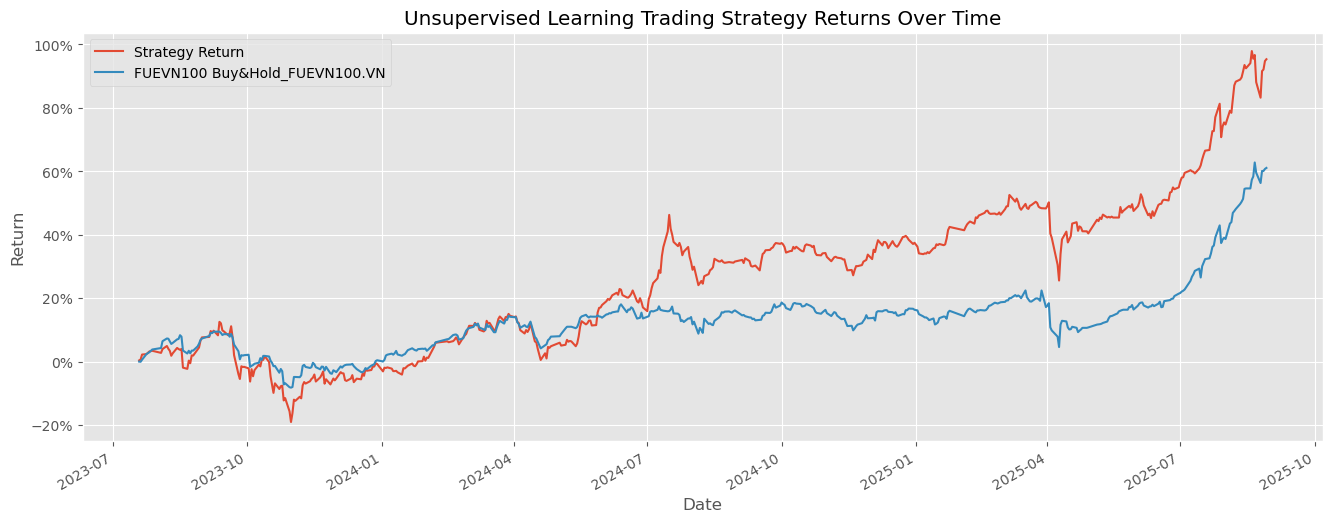

In [72]:
import matplotlib.ticker as mtick

plt.style.use('ggplot')

portfolio_cumulative_return = np.exp(np.log1p(portfolio_df).cumsum())-1

portfolio_cumulative_return[:'2025-08-30'].plot(figsize=(16,6))

plt.title('Unsupervised Learning Trading Strategy Returns Over Time')

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.ylabel('Return')

plt.show()
